# Predicting utilization of medical services: bias detection

In this tutorial we illustrate that empirical quantiles can be used to detect prediction bias. Follow the instructions in `cqr/get_meps_data/` folder to download the data set. This experiments replicates Figure 1 in the equalized coverage paper.

The Medical Expenditure Panel Survey (MEPS) 2016 data set, provided by the Agency for Healthcare Research and Quality, contains information on individuals and their utilization of medical services. The features used for modeling include age, marital status, race, poverty status, functional limitations, health status, health insurance type, and more. The goal is to predict the health care system utilization of each individual; a score that reflects the number of visits to a doctor’s office, hospital visits, etc. After removing observations with missing entries, there are $n=15656$ observations on $p=139$ features. We set the sensitive attribute $A$ to race, with $A=0$ for non-white and $A=1$ for white individuals, resulting in $n_0=9640$ samples for the first group and $n_1=6016$ for the second.

The code starts by randomly splitting the data into train (80%) and test (20%) sets and standardized the features to have zero mean and unit variance; the means and variances are computed using the training examples. We also transform the response variable by $Y = \log(1 + (\text{utilization score}))$ as the raw score is highly skewed.

In [1]:
import os
import sys
import torch
import random
import numpy as np
np.warnings.filterwarnings('ignore')

from cqr import helper
from datasets import datasets
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# set some arbitrary seed for reproducability 
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

save_figures = 0
dataset_name = "meps_21"

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# path to meps data set, download by following the instructions in ./cqr/get_meps_data/
dataset_base_path = '/Users/romano/mydata/regression_data/'

# used to determine the size of test set
test_ratio = 0.2

# load the dataset
X, y = datasets.GetDataset(dataset_name, dataset_base_path)

# display basic information
print("Data set name: %s" % (dataset_name))
print("Data set dimensions: (n=%d, p=%d)" % 
      (X.shape[0], X.shape[1]))

print("A=0 : non-white")
print("A=1 : white")
print("Samples per group: A=0 (n=%d) ; A=1 (n=%d)" % 
      (X[X[:,-1]==0].shape[0], X[X[:,-1]==1].shape[0]))

dataset_name_group_0 = dataset_name + "_non_white"
dataset_name_group_1 = dataset_name + "_white"

# divide the dataset into test and train based on the test_ratio parameter
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(X,
                                                                        y,
                                                                        test_size=test_ratio,
                                                                        random_state=random_state_train_test)


# zero mean and unit variance scaling 
scalerX = StandardScaler()
scalerX = scalerX.fit(x_train_orig)

# scale
x_train = scalerX.transform(x_train_orig)
x_test = scalerX.transform(x_test_orig)

y_train = np.log(1.0 + y_train_orig)
y_test = np.log(1.0 + y_test_orig)

# reshape the data
y_train = np.squeeze(np.asarray(y_train))
y_test = np.squeeze(np.asarray(y_test))

# compute input dimensions
n_train = x_train.shape[0]
in_shape = x_train.shape[1]

print("Train set (n=%d, p=%d) ; Test set (n=%d, p=%d)" % 
      (x_train.shape[0], x_train.shape[1], x_test.shape[0], x_test.shape[1]))

Data set name: meps_21
Data set dimensions: (n=15656, p=139)
A=0 : non-white
A=1 : white
Samples per group: A=0 (n=9640) ; A=1 (n=6016)
Train set (n=12524, p=139) ; Test set (n=3132, p=139)


Next, we fit a neural network regression function on the training set.

In [2]:
# pytorch's optimizer object
nn_learn_func = torch.optim.Adam

# number of epochs
epochs = 1000

# learning rate
lr = 0.0005

# mini-batch size
batch_size = 64

# hidden dimension of the network
hidden_size = 64

# dropout regularization rate
dropout = 0.1

# weight decay regularization
wd = 1e-6

# seed for splitting the data in cross-validation.
cv_test_ratio = 0.1

# ratio of held-out data, used in cross-validation
cv_random_state = 1

model = helper.MSENet_RegressorAdapter(model=None,
                                       fit_params=None,
                                       in_shape = in_shape,
                                       hidden_size = hidden_size,
                                       learn_func = nn_learn_func,
                                       epochs = epochs,
                                       batch_size=batch_size,
                                       dropout=dropout,
                                       lr=lr,
                                       wd=wd,
                                       test_ratio=cv_test_ratio,
                                       random_state=cv_random_state)
    
model.fit(x_train,y_train)
predictions = model.predict(x_test)
MSE = np.mean((predictions - y_test)**2)

print('Test MSE = ' + str(MSE))

Test MSE = 0.77782035


Below, we compute the signed residuals of the test samples,
$$R_i = Y_i - \hat{Y}_i,$$
where $\hat{Y}_i $ is the predicted response, and then compute the resulting empirical cumulative distribution functions $\mathbb{P}\{R \leq r | A=0\}$ and $\mathbb{P}\{R \leq r | A=1\}$.

In [3]:
# function that extracts the group identifier
def condition(x, y=None):
    return int(x[0][-1]>0)

# extract groups
category_map = np.array([condition((x_test[i, :], None)) for i in range(x_test.shape[0])])
categories = np.unique(category_map)

# compute quantiles
signed_residual = (y_test - predictions)
signed_residual_0 = signed_residual[category_map == 0]
signed_residual_1 = signed_residual[category_map == 1]

# compute alpha/2 and 1-alpha/2 quantiles
def compute_lo_hi_q(residuals, alpha):
    err_high = np.reshape(residuals, (residuals.shape[0],1))
    err_low = np.reshape(-residuals, (residuals.shape[0],1))
    residuals = np.concatenate((err_low,err_high),1)
    residuals = np.sort(residuals,0)
    index = int(np.ceil((1 - alpha / 2) * (residuals.shape[0]))) - 1
    return -residuals[index,0], residuals[index,1]

# compute 0.05th and 0.95th quantiles per group
lo_0, up_0 = compute_lo_hi_q(signed_residual_0, alpha=0.1)
lo_1, up_1 = compute_lo_hi_q(signed_residual_1, alpha=0.1)
med_0 = sum(signed_residual_0<=0)/len(signed_residual_0)
med_1 = sum(signed_residual_1<=0)/len(signed_residual_1)

print("A=0: median = " + str(med_0) + "; upper quantile = " + str(up_0) + "; lower quantile = " + str(lo_0))
print("A=1: median = " + str(med_1) + "; upper quantile = " + str(up_1) + "; lower quantile = " + str(lo_1))

# compute CDFs
nbins = 100
bins = np.linspace(min(signed_residual),max(signed_residual),nbins)

counts_0, bin_edges_0 = np.histogram((signed_residual_0), bins=bins, normed=True)
cdf_0 = np.cumsum(counts_0)

counts_1, bin_edges_1 = np.histogram((signed_residual_1), bins=bins, normed=True)
cdf_1 = np.cumsum(counts_1)

A=0: median = 0.5127405096203849; upper quantile = 1.5930867; lower quantile = -1.0478824
A=1: median = 0.45492142266335817; upper quantile = 1.83082; lower quantile = -1.2507485


The next cell display the two CDF functions.

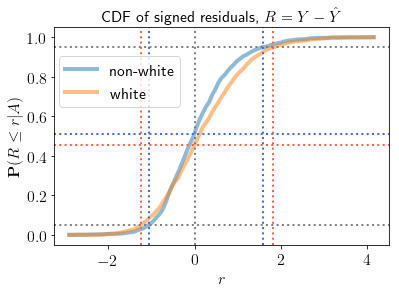

In [4]:
# display results

SMALL_SIZE = 16
MEDIUM_SIZE = SMALL_SIZE
BIGGER_SIZE = SMALL_SIZE

pyplot.rc('font', size=SMALL_SIZE)          # controls default text sizes
pyplot.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
pyplot.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
pyplot.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
pyplot.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
pyplot.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pyplot.rc('text', usetex=True)
pyplot.plot(bin_edges_0[1:], cdf_0/cdf_0[-1], alpha=0.5, linewidth=4, label='non-white')
pyplot.plot(bin_edges_1[1:], cdf_1/cdf_1[-1], alpha=0.5, linewidth=4, label='white')
pyplot.axvline(0, color='gray',linestyle=':',linewidth=2)
pyplot.axhline(med_0, color='royalblue',linestyle=':',linewidth=2)
pyplot.axhline(med_1, color='tomato',linestyle=':',linewidth=2)
pyplot.axvline(up_0, color='royalblue',linestyle=':',linewidth=2)
pyplot.axvline(lo_0, color='royalblue',linestyle=':',linewidth=2)
pyplot.axvline(up_1, color='tomato',linestyle=':',linewidth=2)
pyplot.axvline(lo_1, color='tomato',linestyle=':',linewidth=2)
pyplot.axhline(0.05, color='gray',linestyle=':',linewidth=2)
pyplot.axhline(0.95, color='gray',linestyle=':',linewidth=2)

pyplot.title('CDF of signed residuals, $R=Y-\hat{Y}$')
pyplot.ylabel(r'$\mathbf{P}(R \leq r | A)$')
pyplot.xlabel(r'$r$')
pyplot.legend(loc='center right', bbox_to_anchor=(0.4, 0.75))

if save_figures:
    filename = "CDF_combined_q.png"
    pyplot.savefig(filename, bbox_inches='tight', dpi=300)
    
pyplot.show()

Observe that $\mathbb{P}\{R \leq r | A=0\} \neq \mathbb{P}\{R \leq r | A=1\}$. In particular, when comparing the two functions at $r=0$, we see that the fitted regression function overestimates the response of the non-white group and underestimates the response of the white group, as
$$
\mathbb{P}\{Y \leq \hat{Y} | A=0\} = 0.51 > 0.45 = \mathbb{P}\{Y \leq \hat{Y} | A=1\}.
$$